# Snuffelfiets kwartaalrapportages

## Settings.

In [2]:
# Generieke imports, variabelen en functies.

from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd

from snuffelfiets import inlezen, opschonen, analyse, plotting

In [3]:
api_key = ''  # voeg hier de API key toe

data_directory = Path('~','snuffelfiets').expanduser()
# data_directory = Path('~','kwartaalrapportage').expanduser()
prefix = 'api_gegevens'

# date range selection settings
quarter = 'Q1'
year = 2024
quarters = {
    'Q1': [1, 2, 3], 
    'Q2': [4, 5, 6], 
    'Q3': [7, 8, 9], 
    'Q4': [10, 11, 12], 
}
yq = f'{year}_{quarter}'


In [4]:
# data processing settings
error_code_selection = []
rit_splitter_interval = 1800  # s
ritfilters = dict(
    min_measurements=2,     # #
    max_duration=360,       # minutes
    max_distance=200,       # kilometers
    min_average_speed=1,    # km/h
    max_average_speed=35,   # km/h
    )
threshold_pm2_5 = 100

# mapbox settings (in degrees latlon)
b = {
    'N': [52.303634, 5.013507],
    'Z':  [51.858631, 5.040462],
    'O':  [51.954780, 5.627990],
    'W':  [52.226808, 4.794457],
}
mapbox_center = {
    'lat': b['Z'][0] + 0.5 * (b['N'][0] - b['Z'][0]),
    'lon': b['W'][1] + 0.5 * (b['O'][1] - b['W'][1]),
}
mapbox_extent = 1
hexagon_size = 0.010
hexbin_args = {
    'agg_func': np.nanmean,
    'color_continuous_scale': plotting.discrete_colorscale(),
    'range_color': [0, threshold_pm2_5],
    'min_count': 2,
    'animation_frame': None,
    'width': 1920,
    'height': 1080,
    'opacity': 1.0,
    'zoom': 10,
    'center': mapbox_center,
    }
# add Utrecht polygons

# Import Utrecht province and township polygons
filepaths = plotting.download_borders_utrecht(data_directory)
provincies, gemeenten = plotting.get_borders_utrecht(data_directory, *filepaths)
mapbox_layers = [{
    "name": "Gemeenten",
    "below": 'traces',
    "sourcetype": "geojson",
    "type": "line",
    "color": "gray",
    "source": gemeenten,
    }, 
    {
    "name": "Provincies",
    "below": 'traces',
    "sourcetype": "geojson",
    "type": "line",
    "color": "red",
    "source": provincies,
    }]
layout_args = {
    'mapbox_style': 'open-street-map',
    'coloraxis_showscale': False,
    'mapbox_layers': mapbox_layers,
    }

# Directories
output_directory = Path(data_directory, yq)
output_directory.mkdir(parents=True, exist_ok=True)

print(f'Analysing quarter {yq}; writing output to {output_directory}.')


Analysing quarter 2024_Q1; writing output to /Users/amferraboli/snuffelfiets/2024_Q1.


## Read data with API and save as monthly CSV.

This data is uploaded to the Google Drive of the MCU dataclub:
Dataclub MCU > Project Snuffelfiets > data > api_gegevens_{????}-{??}.csv

In [ ]:
years = [2024]  # [2021, 2022, 2023]
months = range(2, 3)  # range(1, 13)

for y in years:
    for m in months:
        inlezen.monthly_csv_dump(api_key, y, m, data_directory, prefix)


## Read data from monthly CSV's.


In [5]:
# Read data from saved csvs.
dfs = []
for m in quarters[quarter]:
    filename = f'{prefix}_{year}-{m:02d}.csv' #reading m with minimum of 2 integer digits, completing with zeroes
    # p = Path(data_directory, filename)
    df = pd.read_csv(filename)
    dfs.append(df)
df = pd.concat(dfs)

print(f'Read {df.shape[0]} measurements.')


Read 676664 measurements.


## Data preparation

In [6]:
# Get some insight in the error modes present in the dataset.
opschonen.analyse_errors(df)


code          0: count          617086
code         32: count           32187
             32:                        type       : Allowed Error, device maybe indoors
             32:                        description: GPS ERROR 2: No GPS Fix
code        512: count             792
            512:                        type       : Critical Error
            512:                        description: PM ERROR 1: Sensor Not Found
code        533: count            2146
              1:                        type       : Critical Error
              1:                        description: ACCELEROMETER ERROR 1: Sensor Not Found
              4:                        type       : Critical Error
              4:                        description: BME ERROR 1: Sensor Not Found
             16:                        type       : Critical Error
             16:                        description: GPS ERROR 1: Sensor Not Found
            512:                        type       : Critical Err

In [7]:
# Drop the errors.
df = opschonen.verwijder_errors(df, error_codes=error_code_selection)


Removing             792 measurements with error_code             512
Removing           32187 measurements with error_code              32
Removing              33 measurements with error_code             544
Removing           22180 measurements with error_code            2048
Removing            1599 measurements with error_code            2080
Removing             132 measurements with error_code            2560
Removing              66 measurements with error_code            2592
Removing             421 measurements with error_code             552
Removing            2146 measurements with error_code             533
Removing              22 measurements with error_code             573

Error codes remaining: [0]
Measurements remaining: 617086.


In [8]:
# Convert timestamps to datetime objects and add dt columns.
df = analyse.bewerk_timestamp(df, split=True)


Added ['date_time', 'day', 'week', 'month', 'quarter', 'year'] columns to dataframe.


In [9]:
# Split measurements into rides and add cycle stat columns.
df = analyse.split_in_ritten(df, t_seconden=rit_splitter_interval)


/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:198: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_id['duur'][rit_mask] = np.timedelta64(0, 's')
/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:211: FutureWarning: ChainedAs

Added ['duur', 'afstand', 'snelheid', 'rit_id'] columns to dataframe.


/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:211: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_id['afstand'][rit_mask] = 0.
/Users/amferraboli/Snuffelfiets/snuffelfiets/analyse.py:198: FutureWarning: ChainedAssignmentError: be

In [10]:
# Filter the rides.
df = analyse.filter_ritten(df, **ritfilters)


        16 rides were removed because number of measurements was < 2
        54 rides were removed because duration was >= 360 minutes
         0 rides were removed because distance was >= 200 kilometers
         7 rides were removed because average speed was >= 35 km/h
       488 rides were removed because average speed was < 1 km/h


## Summary Snuffelfiets statistics.

In [22]:
def printfun(period, sumstats):

    print(f'\n==== {period} ====\n')

    print(f"Aantal fietsers: {sumstats['fietsers']['N']}\n")

    print(f"{' ':20} {'totaal':12} {'gemiddeld':12} {'topper':12}")
    print(f'-' * 56)
    stat = 'uren'
    print(f"FIETSTIJD [uur]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'afstand'
    print(f"AFSTAND    [km]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'ritten'
    print(f"RITTEN      [#]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")


In [23]:
# Print the summary statistics for the quarter.
sumstats = analyse.summary_stats(df)
printfun(quarter, sumstats)



==== Q1 ====

Aantal fietsers: 64

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:   2011.685000    31.432578   131.000000
AFSTAND    [km]:  23620.964114   369.077564  1918.847487
RITTEN      [#]:   3858.000000    60.281250   248.000000


In [24]:
# Print the summary statistics for the months in the quarter.
for m, dfm in df.groupby('month'):
    sumstats = analyse.summary_stats(dfm)
    printfun(f'{year}{m:02d}', sumstats)



==== 202401 ====

Aantal fietsers: 49

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    585.483611    11.948645    36.000000
AFSTAND    [km]:   6519.356964   133.048101   384.577599
RITTEN      [#]:   1228.000000    25.061224    77.000000

==== 202402 ====

Aantal fietsers: 52

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    641.170278    12.330198    46.000000
AFSTAND    [km]:   7728.611476   148.627144   734.035939
RITTEN      [#]:   1207.000000    23.211538    85.000000

==== 202403 ====

Aantal fietsers: 49

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    785.031111    16.021043    56.000000
AFSTAND    [km]:   9372.995674   191.285626   850.983398
RITTEN      [#]:   1423.000000    29.040816    86.000000


## Air quality evaluation

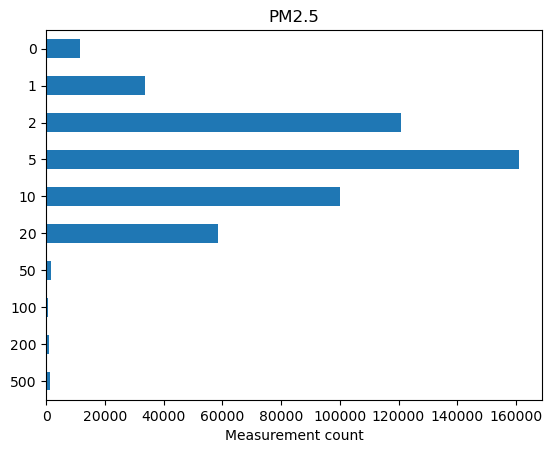

In [11]:
# Plot categorical hist of PM2.5 values.
def plot_hbar_cat(df, bins, labels, title=''):
    df[f'{var}_cat'] = pd.cut(df[var], bins=bins, labels=labels)
    ax = df[['entity_id', f'{var}_cat']].groupby(f'{var}_cat', observed=False).count().plot.barh(stacked=True, legend=False)
    ax.invert_yaxis()
    ax.axes.get_yaxis().get_label().set_visible(False)
    ax.axes.get_xaxis().set_label_text("Measurement count")
    ax.set_title(title)

var = 'pm2_5'
bins = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
labels = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_hbar_cat(df, bins, labels, title='PM2.5')


/var/folders/c9/ffw0stlx71d8wxzkj6rb4v1c0000gn/T/ipykernel_3702/2544659271.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pm2_5'][df['pm2_5'] >= threshold_pm2_5] = np.nan


<Axes: >

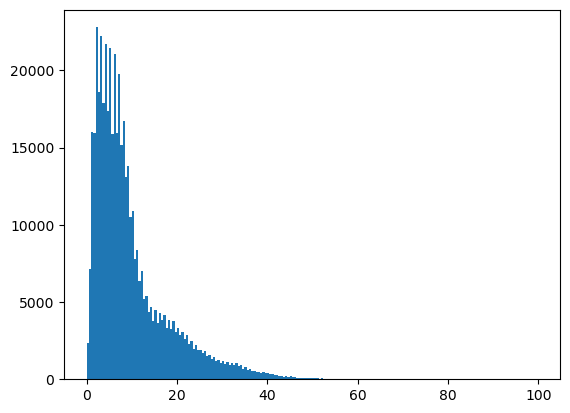

In [16]:
# Limit the PM2.5 values. FIXME: we need a better and validated method
df['pm2_5'][df['pm2_5'] >= threshold_pm2_5] = np.nan

# Plot the histogram.
df['pm2_5'].hist(bins=200, grid=False)


In [27]:
## Hexbin plots of PM2.5

# Remove datapoints outside of the map area 
#   because it would take a very long time to process large areas.
#   TODO: doe dit op ritniveau (verwijderen ritten deels of geheel buiten de target area)
latlon = {
    'latitude': {'center': mapbox_center['lat'], 'extent': mapbox_extent},
    'longitude': {'center': mapbox_center['lon'], 'extent': mapbox_extent},
}
df = opschonen.filter_lat_lon(df, latlon)

# Plot the data for each month.
for m, dfm in df.groupby('month'):

    yyyymm = f'{year}{m:02d}'
    hexbin_args['title'] = yyyymm
    fig = plotting.hexbin_mapbox(dfm, hexagon_size, hexbin_args, layout_args)

    # Save image
    filestem = f'{yyyymm}_hexbin'
    output_stem = Path(output_directory, filestem)
    fig.write_html(f"{output_stem}.html")
    fig.write_image(f"{output_stem}.png")
    fig.write_image(f"{output_stem}.pdf")


/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.11/site-packages/plotly/figure_factory/_hexbin_mapbox.py:175: RuntimeWarning: Mean of empty slice
  lattice1[i, j] = agg_func(vals)
/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.11/site-packages/plotly/figure_factory/_hexbin_mapbox.py:182: RuntimeWarning: Mean of empty slice
  lattice2[i, j] = agg_func(vals)
/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.11/site-packages/plotly/figure_factory/_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.11/site-packages/plotly/figure_factory/_hexbin_mapbox.py:182: RuntimeWarning:

Mean of empty slice

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.11/site-packages/plotly/figure_factory/_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

/opt/homebrew/Caskroom/miniforge/base/envs/snuffelfiets/lib/python3.11/site-packages/plotly/figu

### Custom analysis explorations

- Speed vs particulate
- Highlight days: Compare dates on days when there are events in Utrecht: 1st of Jan, Easter, Kings day. 
- Compare particulate days of the week
- Weather: sun contributes to particulate? maybe not the sun itself, but more people outside? use temperature to prove point. 

In [12]:
df.columns

Index(['entity_id', 'vertical_accuracy', 'voc', 'voltage', 'acc_max', 'no2',
       'temperature', 'version_major', 'latitude', 'pm2_5',
       'horizontal_accuracy', 'receive_timestamp', 'pressure', 'pm1_0',
       'version_minor', 'pm10', 'longitude', 'humidity', 'recording_timestamp',
       '_id', 'error_code', 'date_time', 'day', 'week', 'month', 'quarter',
       'year', 'duur', 'rit_id', 'afstand', 'snelheid', 'pm2_5_cat'],
      dtype='object')

### Snelheid vs particulate: 
does speed influence in the measurement of particulate? Apparently, if the speed is higher than 10, the particulate is always lower than 40.

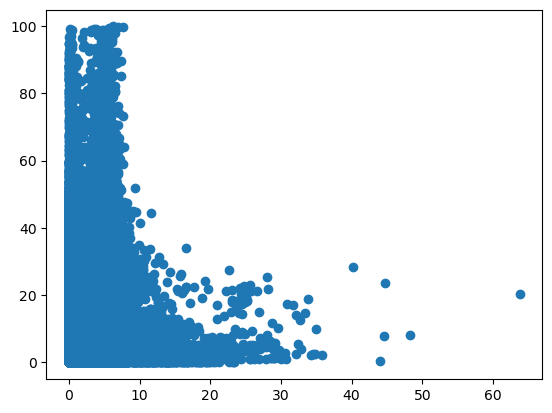

In [17]:
import matplotlib.pyplot as plt
df_test = df.loc[df['snelheid']<100]
plt.scatter(df_test['snelheid'],df_test['pm2_5'])
plt.show()

### Events day vs particulate

In [18]:
def adjust_day(row):
    if row['month'] == 2:
        return row['day'] - 31
    elif row['month'] == 3:
        return row['day'] - 60
    else:
        return row['day']


In [19]:
df_pm_day = df.loc[:, ['pm2_5', 'day', 'month', 'year']].groupby(['day', 'month', 'year']).mean().reset_index()
df_pm_day['day'] = df_pm_day.apply(adjust_day, axis=1)
df_pm_day

,day,month,year,pm2_5
0,1.0,1,2024,4.390532
1,2.0,1,2024,5.160515
2,3.0,1,2024,4.573433
3,4.0,1,2024,4.160386
4,5.0,1,2024,5.311997
...,...,...,...,...
86,27.0,3,2024,7.039482
87,28.0,3,2024,3.063457
88,29.0,3,2024,2.494766
89,30.0,3,2024,6.705122


In [20]:
import datetime

df_pm_day['full_day'] = pd.to_datetime(df_pm_day[['year', 'month', 'day']])
df_pm_day['weekday'] = df_pm_day['full_day'].apply(lambda x: x.weekday())
df_pm_day

,day,month,year,pm2_5,full_day,weekday
0,1.0,1,2024,4.390532,2024-01-01,0
1,2.0,1,2024,5.160515,2024-01-02,1
2,3.0,1,2024,4.573433,2024-01-03,2
3,4.0,1,2024,4.160386,2024-01-04,3
4,5.0,1,2024,5.311997,2024-01-05,4
...,...,...,...,...,...,...
86,27.0,3,2024,7.039482,2024-03-27,2
87,28.0,3,2024,3.063457,2024-03-28,3
88,29.0,3,2024,2.494766,2024-03-29,4
89,30.0,3,2024,6.705122,2024-03-30,5


In [50]:
colors_dict = {0:"pink",
     1:"green",
     2:"orange",
     3:"red",
     4:"yellow",
     5:"purple",
     6:"blue"}

weekday_dict = {0:"monday",
     1:"tuesday",
     2:"wednesday",
     3:"thursday",
     4:"friday",
     5:"saturday",
     6:"sunday"}

color_list = df_pm_day['weekday'].map(colors_dict).tolist()


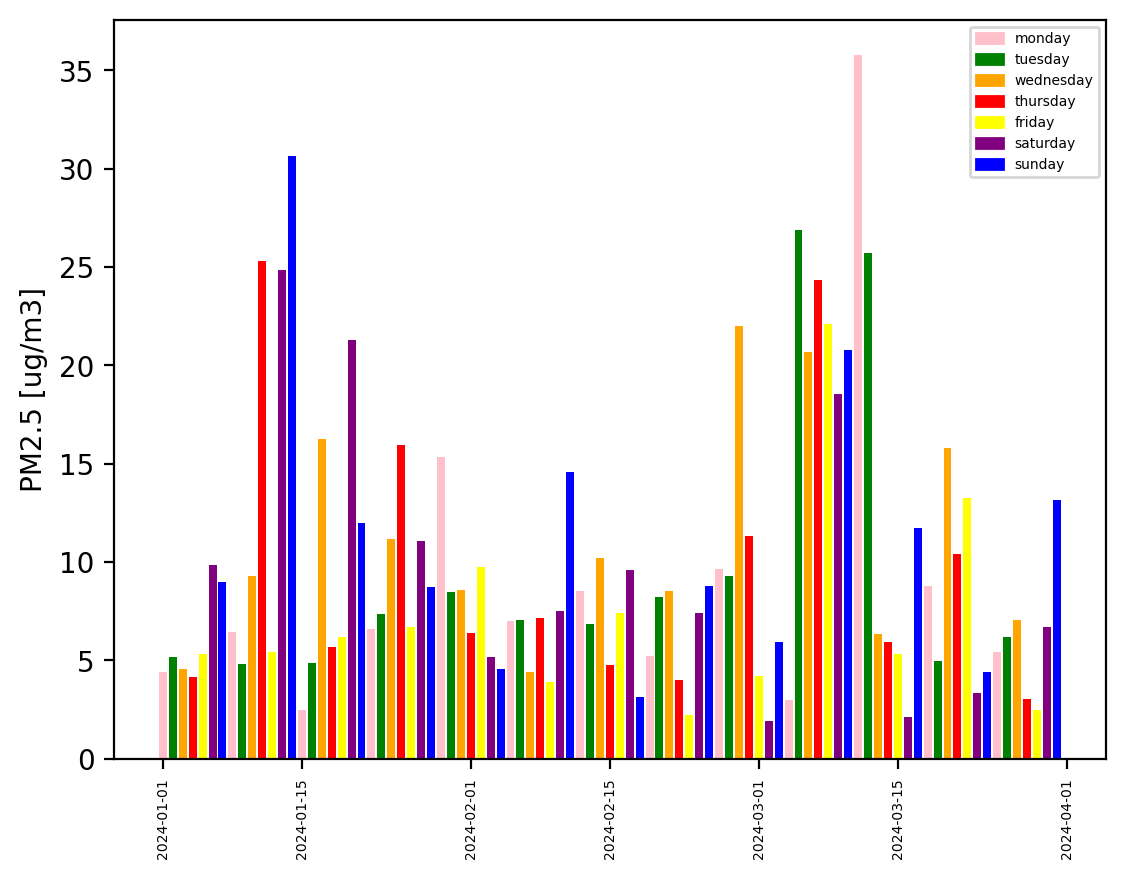

In [57]:
fig, ax_day = plt.subplots(dpi=200)
ax_day.bar(df_pm_day['full_day'], df_pm_day['pm2_5'], color = color_list)
#ax_day = sns.barplot(data = df_pm_day, x = df_pm_day['full_day'], y = df_pm_day['pm2_5'], hue = df_pm_day['weekday'])
ax_day.tick_params(axis='x', labelrotation=90, labelsize=5)

labels = list(colors_dict.keys())
handles = [plt.Rectangle((1,1),0.5,0.5, color=colors_dict[label], label=weekday_dict[label]) for label in labels]
plt.legend(handles=handles, loc='upper right', fontsize=5)

ax_day.set_ylabel('PM2.5 [ug/m3]')

plt.savefig("weekday_pm2_5.jpg", bbox_inches = "tight")

In [55]:
df_pm_day.sort_values("pm2_5", ascending=False)

,day,month,year,pm2_5,full_day,weekday
70,11.0,3,2024,35.786969,2024-03-11,0
13,14.0,1,2024,30.666261,2024-01-14,6
64,5.0,3,2024,26.862734,2024-03-05,1
71,12.0,3,2024,25.695186,2024-03-12,1
10,11.0,1,2024,25.282538,2024-01-11,3
...,...,...,...,...,...,...
88,29.0,3,2024,2.494766,2024-03-29,4
14,15.0,1,2024,2.456924,2024-01-15,0
53,23.0,2,2024,2.217714,2024-02-23,4
75,16.0,3,2024,2.145118,2024-03-16,5


## Uitgelicht 2023-Q1: Fijnstof en regen.

In [59]:
# Specify the date range.
import calendar
months = quarters[quarter]
lastday = calendar.monthrange(year, quarters[quarter][2])[1]
dt_min = f'{year}-{months[0]}-1 00:00:00'
dt_max = f'{year}-{months[2]}-{lastday} 23:59:59'

# Import the weather data.
dfr = analyse.import_knmi_data(dt_min, dt_max, interval='dag', stations=[260], variables=['RH'])
dfr.RH = dfr.RH.values / 10  # RH: Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)


In [60]:
# Print the monthly pm2.5 average.
df.loc[: , ['month', 'pm2_5']].groupby('month').mean()


,pm2_5
month,
1,10.225224
2,7.968650
3,11.133020


In [61]:
# Print the monthly rainfall sum.
dfr['month'] = dfr.index.month
dfr.loc[: , ['month', 'RH']].groupby('month').sum()


,RH
month,
1,94.5
2,122.3
3,57.7


In [62]:
# Calculate the mean daily PM2.5 value.
sfday = df.loc[:, ['pm2_5', 'day', 'month', 'year']].groupby(['day', 'month', 'year']).mean()

# Add to the weather data frame.
dfr['pm2_5'] = np.array(sfday['pm2_5'])


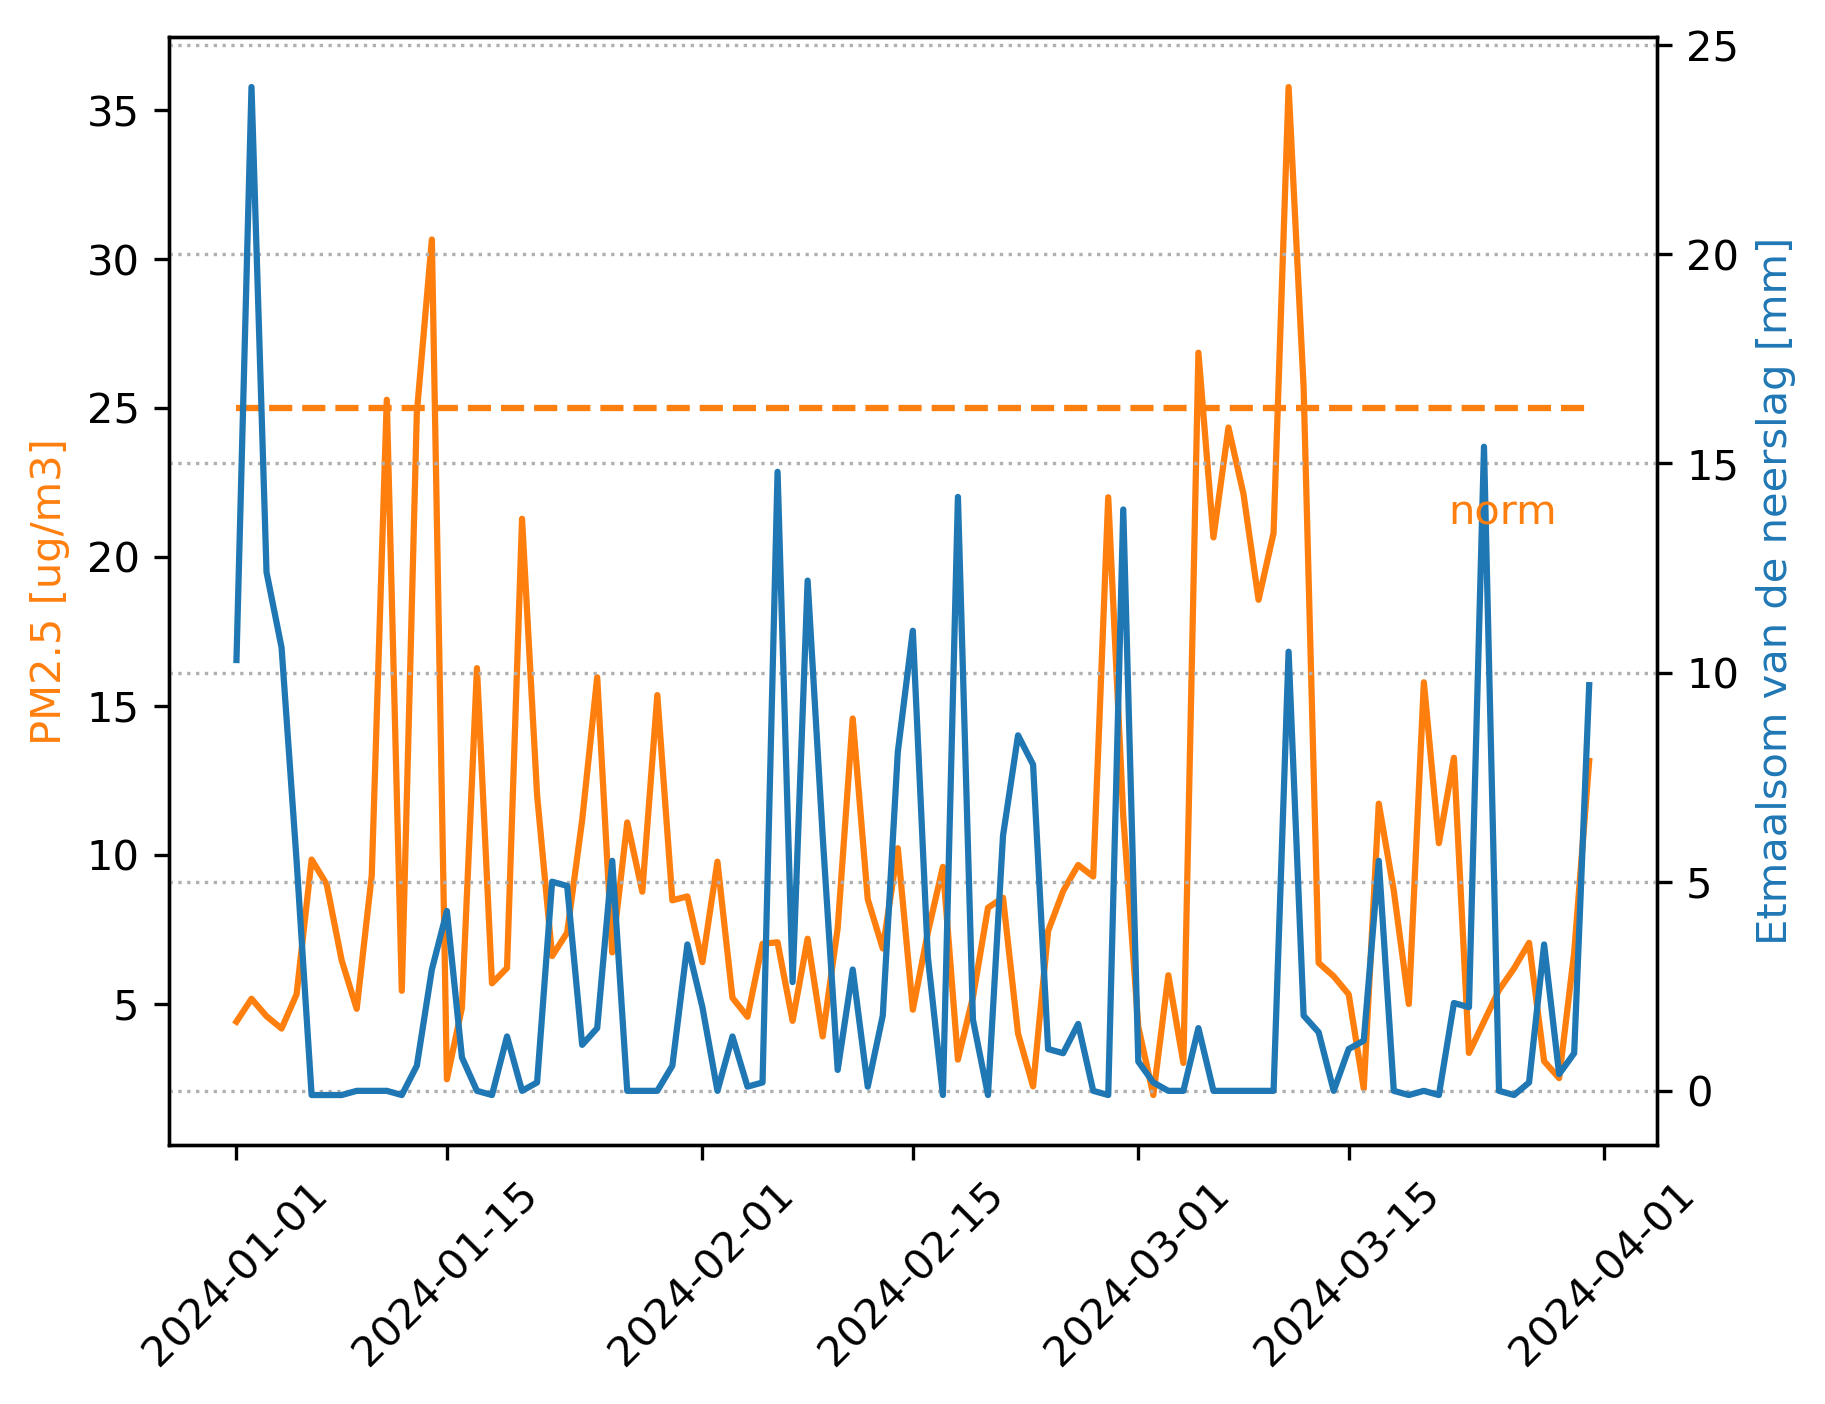

In [63]:
# Plot the data.
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(dpi=300)
ax2 = ax1.twinx()

ax1.plot(dfr.index, dfr.pm2_5, c='C1')
ax2.plot(dfr.index, dfr.RH, c='C0')

ax1.set_ylabel('PM2.5 [ug/m3]', color='C1')
ax2.set_ylabel('Etmaalsom van de neerslag [mm]', color='C0')

ax1.plot([dfr.index[0], dfr.index[-1]], [25, 25], c='C1',linestyle='--')
plt.text(0.86, 0.56, 'norm', c='C1', transform=ax1.transAxes)
ax1.xaxis.set_tick_params(rotation=45)
plt.grid(linestyle=':')
plt.savefig("neerslag.jpg", bbox_inches = "tight")
